Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Maciej Wilhelmi"

---

# 2. Wielomodalne autokodery

Przejdziemy teraz do implementacji modelu **wielomodalnego autokodera**. W przypadku rozważanych przez nas danych, autokoder ten będzie posiadać dwa wejścia oraz dwa wyjścia (wcześniej wyznaczone wektory cech obrazków oraz tekstów).

In [3]:
from typing import Dict, List, Type

import pandas as pd
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.nn import functional as F

from src.dataset import DataModule
from src.downstream import evaluate_classification
from src.nn.unimodal import UnimodalAE
from src.train import extract_embeddings, train_model
from src.visualization import make_interactive_scatter_plot, visualize_most_similar

## Zadanie 2.1 (2 pkt)
Zaczniemy od implementacji modułu kodera wielomodalnego. Należy uzupełnić poniższą implementację w taki sposób, aby:
- dla każdej modalności (określonej przez parametr `modality_names`) został utworzony modal perceptrona wielowarstwowego (MLP), który będzie przekształcać cechy w danej modalności (pamiętaj aby odpowiednio przypisać moduły PyTorchowe – np. `ModuleList` albo `ModuleDict`)
- MLP dla każdej modalności będzie posiadać taką samą architekturę (z wyłączeniem wymiaru wejściwego) - wykorzystaj podane w konstruktorze parametry dla tych sieci MLP:
  * `in_dims` - wymiary danych wejściowych dla każdej modalności,
  * `hidden_dims` - rozmiary warstw ukrytych, takie same dla każdego MLP,
  * `out_dim` - wyjściowy rozmiar, również takie same dla każdego MLP.
- w metodzie `forward()` przekształć odpowiednie modalności przez przypisane do nich sieci MLP, na wyjściu zwróć listę wektorów

In [28]:
class MultimodalEncoder(nn.Module):

    def __init__(
        self,
        modality_names: List[str],
        in_dims: Dict[str, int],
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
    ):
        super().__init__()

        self.modality_names = modality_names
        
        # TU WPISZ KOD
        
        self.encoders = nn.ModuleDict()
        
        for modality in self.modality_names:
            encoder_layers = []
            
            for i in range(len(hidden_dims)):
                if i == 0:
                    encoder_layers.append(nn.Linear(in_dims[modality], hidden_dims[i]))
                else:
                    encoder_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
                    
                encoder_layers.append(nn.ReLU())
                
            encoder_layers.append(nn.Linear(hidden_dims[-1], out_dim))
            encoder_layers.append(last_activation())
            
            self.encoders[modality] = nn.Sequential(*encoder_layers)
            

    def forward(self, x: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        # TU WPISZ KOD
        outs = []
        
        for modality in self.modality_names:
            out = self.encoders[modality](x[modality])
            outs.append(out)
            
        return outs
        
    @staticmethod
    def from_hparams(hparams):
        return MultimodalEncoder(
            modality_names=hparams["modality_names"],
            in_dims=hparams["data_dims"],
            hidden_dims=hparams["hidden_dims"],
            out_dim=hparams["emb_dim"],
            last_activation=nn.Tanh,
        )


## Zadanie 2.2 (2 pkt)
Zaimplementuj dwie strategie łączenia wektorów ukrytych z różnych modalności w jeden wielomodalny wektor reprezentacji:
- w klasie `AvgFusion` zaimplementuj uśrednianie wektorów z różnych modalności
- w klasie `MLPFusion` skonkatenuj wektory z różnych modalności a następnie przekształć wynik przez sieć MLP (parametry sieci podane w konstruktorze)

In [29]:
class AvgFusion(nn.Module):
    
    def forward(self, h: List[torch.Tensor]) -> torch.Tensor:
        # TU WPISZ KOD
        return torch.mean(torch.stack(h), dim=0)
    
    
class MLPFusion(nn.Module):
    
    def __init__(
        self,
        modality_dim: int,
        num_modalities: int,
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
    ):
        super().__init__()
        
        layers = []
        
        # TU WPISZ KOD
        
        layers = []
        
        layers.append(nn.Linear(modality_dim * num_modalities, hidden_dims[0]))
        layers.append(nn.ReLU())

        in_dim = hidden_dims[0]
        
        for hidden_dim in hidden_dims[1:]:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(last_activation())
        
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, h: List[torch.Tensor]) -> torch.Tensor:
        # TU WPISZ KOD
        concated = torch.cat(h, dim=1)
        return self.mlp(concated)

## Zadanie 2.3 (2 pkt)
Analogicznie do kodera wielomodalnego, musimy zaimplementować moduł wielomodalnego dekodera.
- dla każdej modalności utwórz sieć MLP, która będzie dekodować (rekonstruować) oryginalne atrybuty obiektu w danej modalności:
  * `in_dim` określa wymiar wejściowego wielomodalnego wektora reprezentacji (wspólne dla wszystkich modalności)
  * `hidden_dims` określa rozmiary warstw ukrytych modeli MLP (wspólne dla wszystkich modalności)
  * `out_dims` określa wymiary atrybutów (które chcemy zrekonstruować) w każdej modalności
- w metodzie `forward()` zastosuj utworzone sieci MLP na wielomodalnej reprezentacji `z` i zwróć słownik, w którym klucze określają nazwy modalności a skojarzone wartości to rekonstrukcje atrybutów w danej modalności

In [31]:
class MultimodalDecoder(nn.Module):

    def __init__(
        self,
        modality_names: List[str],
        in_dim: int,
        hidden_dims: List[int],
        out_dims: Dict[str, int],
        last_activation: Type[nn.Module],
    ):
        super().__init__()

        self.modality_names = modality_names
        
        # TU WPISZ KOD
        
        self.decoders = nn.ModuleDict()
        
        for modality in self.modality_names:
            decoder_layers = []
            
            for i in range(len(hidden_dims)):
                if i == 0:
                    decoder_layers.append(nn.Linear(in_dim, hidden_dims[i]))
                else:
                    decoder_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
                    
                decoder_layers.append(nn.ReLU())
                
            decoder_layers.append(nn.Linear(hidden_dims[-1], out_dims[modality]))
            decoder_layers.append(last_activation())
            
            self.decoders[modality] = nn.Sequential(*decoder_layers)
            

    def forward(self, z: torch.Tensor) -> Dict[str, torch.Tensor]:
        # TU WPISZ KOD
        outs = {}
        
        for modality in self.modality_names:
            out = self.decoders[modality](z)
            outs[modality] = out
            
        return outs

## Zadanie 2.4 (2 pkt)
Przeanalizuj implementację klasy bazowej `BaseAE` a następnie dokończ implementację właściwego wielomodalnego autokodera:
- w metodzie `forward()` zastosuj wielomodalny koder `encoder` na podanych danych wejściowych, a następnie połącz listę ukrytych wektorów w jedną wielomodalną reprezentację, wykorzystując moduł fuzji `fusion`
- w metodzie `_common_step()` zaimplementuj krok uczenia autokodera:
  * wyznacz wielomodalną reprezentację `z`
  * przeprowadź rekonstrukcję oryginalnych cech `x_rec` na podstawie reprezentacji `z`
  * oblicz funkcję kosztu jako błąd średniokwadratowy (`MSE`) po każdej modalności, a wartości tych funkcji kosztu uśrednij względem wszystkich modalności

In [32]:
from src.nn.ae import BaseAE
import torch.nn.functional as F



class MultimodalAE(BaseAE):

    def __init__(self, hparams):
        encoder_cls = hparams["encoder_cls"]
        
        super().__init__(
            hparams=hparams,
            encoder=encoder_cls.from_hparams(hparams),
            decoder=MultimodalDecoder(
                modality_names=hparams["modality_names"],
                in_dim=hparams["emb_dim"],
                hidden_dims=hparams["hidden_dims"][::-1],
                out_dims=hparams["data_dims"],
                last_activation=nn.Identity,
            ),
        )
        
        if hparams["fusion"] == "Avg":
            self.fusion = AvgFusion()
        elif hparams["fusion"] == "MLP":
            self.fusion = MLPFusion(
                modality_dim=hparams["emb_dim"],
                num_modalities=len(hparams["modality_names"]),
                hidden_dims=[hparams["emb_dim"], hparams["emb_dim"]],
                out_dim=hparams["emb_dim"],
                last_activation=nn.Tanh,
            )
        else:
            raise ValueError(f"Unknown fusion module: \"{hparams['fusion']}\"")

    def forward(self, batch) -> torch.Tensor:
        encoded_modals = self.encoder(batch)
        multi_repr = self.fusion(encoded_modals)
        
        return multi_repr

    def _common_step(self, batch) -> torch.Tensor:
        # TU WPISZ KOD        
        multi_reps = self.forward(batch)
        r = self.decoder(multi_reps)
        
        mse_losses = [
            F.mse_loss(batch[modality], r[modality])
            for modality in self.decoder.modality_names
        ]
        avg_loss = torch.mean(torch.stack(mse_losses))
        
        return avg_loss
        


In [7]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

In [33]:
default_hparams = {
    "encoder_cls": MultimodalEncoder,
    "modality_names": ["img_emb", "text_emb"],
    "data_dims": {"img_emb": 2048, "text_emb": 384}, 
    "batch_size": 64,
    "num_epochs": 30,
    "hidden_dims": [256, 256, 256],
    "emb_dim": 128,
    "lr": 1e-3,
    "weight_decay": 5e-4,
}

In [34]:
datamodule = DataModule(batch_size=default_hparams["batch_size"])

In [10]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "ImageTextAvgAE",
        "fusion": "Avg",
        **default_hparams,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/ImageTextAvgAE exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/trainer

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [11]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "ImageTextMLPAE",
        "fusion": "MLP",
        **default_hparams,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/ImageTextMLPAE exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | MLPFusion         | 65.9 K
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.889     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [12]:
multimodal_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="ImageTextAvgAE",
    datamodule=datamodule,
)

multimodal_mlp_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="ImageTextMLPAE",
    datamodule=datamodule,
)


In [13]:
make_interactive_scatter_plot(
    title="Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(multimodal_avg_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



In [14]:
make_interactive_scatter_plot(
    title="Multimodal embeddings (MLP)",
    z_2d=PCA(n_components=2).fit_transform(multimodal_mlp_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



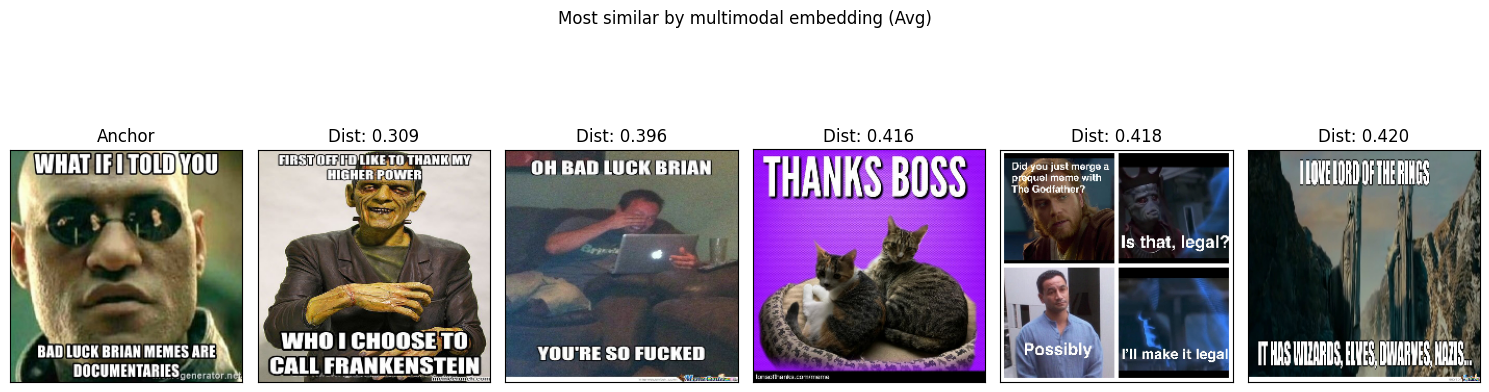

In [15]:
_ = visualize_most_similar(
    title="Most similar by multimodal embedding (Avg)",
    anchor_index=339,
    z=multimodal_avg_emb,
    df=datamodule.df["all"],
)

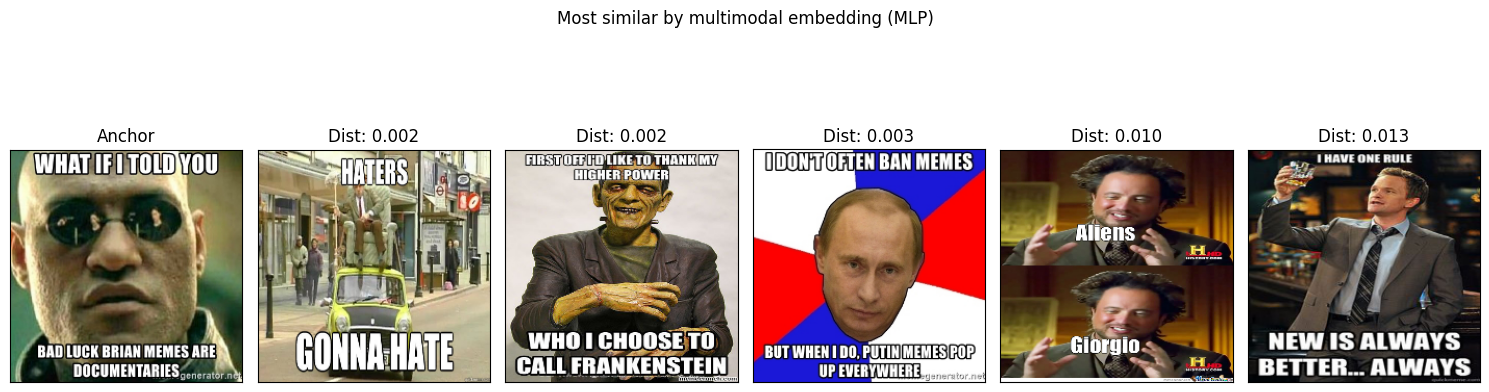

In [16]:
_ = visualize_most_similar(
    title="Most similar by multimodal embedding (MLP)",
    anchor_index=339,
    z=multimodal_mlp_emb,
    df=datamodule.df["all"],
)

In [36]:
evaluate_classification(
    model_names=[
        (UnimodalAE, "ImageAE"), 
        (UnimodalAE, "TextAE"), 
        (MultimodalAE, "ImageTextAvgAE"),
        (MultimodalAE, "ImageTextMLPAE"),
    ],
    datamodule=datamodule,
)

train_AUC                                                 
task               humour motivational  offensive    sarcasm  sentiment   
model                                                                     
ImageAE         56.39 [%]    55.66 [%]  53.64 [%]  56.30 [%]  55.47 [%]  \
TextAE          60.78 [%]    57.53 [%]  62.05 [%]  62.45 [%]  62.34 [%]   
ImageTextAvgAE  56.84 [%]    57.43 [%]  59.99 [%]  60.65 [%]  59.70 [%]   
ImageTextMLPAE  53.15 [%]    51.69 [%]  54.33 [%]  51.93 [%]  52.73 [%]   

                 test_AUC                                                
task               humour motivational  offensive    sarcasm  sentiment  
model                                                                    
ImageAE         50.36 [%]    50.94 [%]  50.40 [%]  49.10 [%]  48.05 [%]  
TextAE          50.55 [%]    44.50 [%]  54.75 [%]  52.85 [%]  46.47 [%]  
ImageTextAvgAE  50.22 [%]    49.59 [%]  54.55 [%]  52.43 [%]  50.71 [%]  
ImageTextMLPAE  52.88 [%]    53.19 [%]  50.73 [%]  52.00 [%]  44.04 [%]

# Maskowane uczenie
Dotychczas wielomodalny autokoder był uczony w taki sposób, że zarówno na wejściu jak i na wyjściu otrzymywał informacje o obrazku, jak i tekście. Teraz zobaczymy jak model się będzie zachowywać w sytuacji, kiedy jedna z modalności będzie **maskowana na wejściu** (można w ten sposób symulować sytuacje, gdy jedna z modalności nie jest dostępna – *brakująca wartość*). 

Zaczniemy od przygotowania nowej implementacji `MultimodalEncoder`.

## Zadanie 2.5 (2 pkt)
Uzupełnij poniższą implementację klasy `MaskedMultimodalEncoder`, która będzie maskować cechy z wybranej modalności z określonym prawdopodobieństwem `p_m`:

- poprzez maskowanie danej modalności rozumiemy zastąpienie wektora cech w tej modalności dla konkretnego obiektu, wektorem składającym się z samych zer
- to czy pojedynczy obiekt będzie poddawany maskowaniu określamy na podstawie prawdopodobieństwa $p_m \in [0, 1]$
- zakładamy, że maskowanie dotyczy tylko etapu uczenia, natomiast w trakcie inferencji używamy dostępnych cech bez jakiejkolwiek modyfikacji

In [43]:
class MaskedMultimodalEncoder(nn.Module):

    def __init__(
        self,
        modality_names: List[str],
        in_dims: Dict[str, int],
        hidden_dims: List[int],
        out_dim: int,
        last_activation: Type[nn.Module],
        masked_modality: str,
        p_m: float,
    ):
        super().__init__()

        self.modality_names = modality_names
        self.masked_modality = masked_modality
        self.p_m = p_m
        
        # TU WPISZ KOD
        
        self.encoders = nn.ModuleDict()
        
        
        for modality in self.modality_names:
            encoder_layers = []
            
            for i in range(len(hidden_dims)):
                if i == 0:
                    encoder_layers.append(nn.Linear(in_dims[modality], hidden_dims[i]))
                else:
                    encoder_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
                    
                encoder_layers.append(nn.ReLU())
                
            encoder_layers.append(nn.Linear(hidden_dims[-1], out_dim))
            encoder_layers.append(last_activation())
            
            self.encoders[modality] = nn.Sequential(*encoder_layers)

    def forward(self, x: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        # TU WPISZ KOD
        encoded_modalities = []

        for modality in self.modality_names:
            inputs = x[modality]

            if modality == self.masked_modality:
                mask = torch.rand(inputs.size()) < self.p_m
                # dla 0 zostawiamy inputy, a dla 1 zamieniamy na 0
                inputs = torch.where(mask, torch.zeros_like(inputs), inputs)


            encoded_modality = self.encoders[modality](inputs)
            encoded_modalities.append(encoded_modality)

        return encoded_modalities
        
    @staticmethod
    def from_hparams(hparams):
        return MaskedMultimodalEncoder(
            modality_names=hparams["modality_names"],
            in_dims=hparams["data_dims"],
            hidden_dims=hparams["hidden_dims"],
            out_dim=hparams["emb_dim"],
            last_activation=nn.Tanh,
            masked_modality=hparams["masked_modality"],
            p_m=hparams["p_m"],
        )

In [21]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedImage_ImageTextAvgAE",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "img_emb",
        "p_m": 1.0,
    },
    datamodule=datamodule,
)

train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedText_ImageTextAvgAE",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "text_emb",
        "p_m": 1.0,
    },
    datamodule=datamodule,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/MaskedText_ImageTextAvgAE

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [38]:
masked_image_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="MaskedImage_ImageTextAvgAE",
    datamodule=datamodule,
)

masked_text_avg_emb = extract_embeddings(
    model_cls=MultimodalAE, 
    name="MaskedText_ImageTextAvgAE",
    datamodule=datamodule,
)


In [23]:
make_interactive_scatter_plot(
    title="Masked Image (p_m = 1.0) - Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(masked_image_avg_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



In [24]:
make_interactive_scatter_plot(
    title="Masked Text (p_m = 1.0) - Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(masked_text_avg_emb),
    df=datamodule.df["all"],
)

Dash is running on http://127.0.0.1:8050/



In [25]:
evaluate_classification(
    model_names=[
        (UnimodalAE, "ImageAE"), 
        (UnimodalAE, "TextAE"), 
        (MultimodalAE, "ImageTextAvgAE"),
        (MultimodalAE, "ImageTextMLPAE"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE"),
    ],
    datamodule=datamodule,
)

train_AUC                                      
task                           humour motivational  offensive    sarcasm   
model                                                                      
ImageAE                     56.39 [%]    55.66 [%]  53.64 [%]  56.30 [%]  \
TextAE                      60.78 [%]    57.53 [%]  62.05 [%]  62.45 [%]   
ImageTextAvgAE              56.84 [%]    57.43 [%]  59.99 [%]  60.65 [%]   
ImageTextMLPAE              53.15 [%]    51.69 [%]  54.33 [%]  51.93 [%]   
MaskedImage_ImageTextAvgAE  56.47 [%]    57.11 [%]  59.12 [%]  60.03 [%]   
MaskedText_ImageTextAvgAE   56.79 [%]    58.16 [%]  58.52 [%]  60.33 [%]   

                                        test_AUC                           
task                        sentiment     humour motivational  offensive   
model                                                                      
ImageAE                     55.47 [%]  50.36 [%]    50.94 [%]  50.40 [%]  \
TextAE                      62.34 [%]  50.55 [%]    44.50 [%]  54.75 [%]   
ImageTextAvgAE              59.70 [%]  50.22 [%]    49.59 [%]  54.55 [%]   
ImageTextMLPAE              52.73 [%]  52.88 [%]    53.19 [%]  50.73 [%]   
MaskedImage_ImageTextAvgAE  60.10 [%]  50.92 [%]    47.28 [%]  54.65 [%]   
MaskedText_ImageTextAvgAE   60.59 [%]  50.14 [%]    48.07 [%]  56.26 [%]   

                                                  
task                          sarcasm  sentiment  
model                                             
ImageAE                     49.10 [%]  48.05 [%]  
TextAE                      52.85 [%]  46.47 [%]  
ImageTextAvgAE              52.43 [%]  50.71 [%]  
ImageTextMLPAE              52.00 [%]  44.04 [%]  
MaskedImage_ImageTextAvgAE  51.79 [%]  50.39 [%]  
MaskedText_ImageTextAvgAE   52.18 [%]  50.03 [%]

## Zadanie 2.6 (2 pkt)
Zbadaj jak wartość parametru `p_m` wpływa na jakość otrzymywanych multimodalnych wektorów reprezentacji? (Skrajne wartości `p_m = 0` oraz `p_m = 1` zbadaliśmy w poprzednich przykładach). Skomentuj otrzymane wyniki.

In [46]:
def check_masking_probability_performance():
    # TU WPISZ KOD
    train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedImage_ImageTextAvgAE_0.6",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "img_emb",
        "p_m": 0.6,
    },
    datamodule=datamodule,
    )

    train_model(
        model_cls=MultimodalAE,
        hparams={
            **default_hparams,
            "name": "MaskedText_ImageTextAvgAE_0.6",
            "fusion": "Avg",
            "encoder_cls": MaskedMultimodalEncoder,
            "masked_modality": "text_emb",
            "p_m": 0.6,
        },
        datamodule=datamodule,
    )
    
    train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedImage_ImageTextAvgAE_0.3",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "img_emb",
        "p_m": 0.3,
    },
    datamodule=datamodule,
    )

    train_model(
        model_cls=MultimodalAE,
        hparams={
            **default_hparams,
            "name": "MaskedText_ImageTextAvgAE_0.3",
            "fusion": "Avg",
            "encoder_cls": MaskedMultimodalEncoder,
            "masked_modality": "text_emb",
            "p_m": 0.3,
        },
        datamodule=datamodule,
    )
    
    train_model(
    model_cls=MultimodalAE,
    hparams={
        **default_hparams,
        "name": "MaskedImage_ImageTextAvgAE_0.0",
        "fusion": "Avg",
        "encoder_cls": MaskedMultimodalEncoder,
        "masked_modality": "img_emb",
        "p_m": 0.0,
    },
    datamodule=datamodule,
    )

    train_model(
        model_cls=MultimodalAE,
        hparams={
            **default_hparams,
            "name": "MaskedText_ImageTextAvgAE_0.0",
            "fusion": "Avg",
            "encoder_cls": MaskedMultimodalEncoder,
            "masked_modality": "text_emb",
            "p_m": 0.0,
        },
        datamodule=datamodule,
    )   

In [47]:
check_masking_probability_performance()

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/MaskedImage_ImageTextAvgAE_0.6 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/l

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/MaskedText_ImageTextAvgAE_0.6 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (M

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/MaskedImage_ImageTextAvgAE_0.3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/MaskedText_ImageTextAvgAE_0.3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (M

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/MaskedImage_ImageTextAvgAE_0.0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cusiowaty24/opt/anaconda3/envs/pmg2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/cusiowaty24/Documents/GitHub/l06-pt-15-wmaciek/data/checkpoints/MaskedText_ImageTextAvgAE_0.0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type                    | Params
----------------------------------------------------
0 | encoder | MaskedMultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder       | 954 K 
2 | fusion  | AvgFusion               | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (M

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [49]:
evaluate_classification(
    model_names=[
        (MultimodalAE, "MaskedImage_ImageTextAvgAE"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE_0.6"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE_0.3"),
        (MultimodalAE, "MaskedImage_ImageTextAvgAE_0.0"),

        (MultimodalAE, "MaskedText_ImageTextAvgAE"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE_0.6"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE_0.3"),
        (MultimodalAE, "MaskedText_ImageTextAvgAE_0.0"),
    ],
    datamodule=datamodule,
)

train_AUC                                      
task                               humour motivational  offensive    sarcasm   
model                                                                          
MaskedImage_ImageTextAvgAE      56.47 [%]    57.11 [%]  59.12 [%]  60.02 [%]  \
MaskedImage_ImageTextAvgAE_0.6  56.48 [%]    57.11 [%]  59.11 [%]  60.04 [%]   
MaskedImage_ImageTextAvgAE_0.3  56.48 [%]    57.11 [%]  59.11 [%]  60.03 [%]   
MaskedImage_ImageTextAvgAE_0.0  56.47 [%]    57.11 [%]  59.12 [%]  60.03 [%]   
MaskedText_ImageTextAvgAE       54.64 [%]    54.22 [%]  56.12 [%]  55.32 [%]   
MaskedText_ImageTextAvgAE_0.6   55.84 [%]    59.12 [%]  58.35 [%]  59.13 [%]   
MaskedText_ImageTextAvgAE_0.3   56.21 [%]    56.48 [%]  57.01 [%]  59.58 [%]   
MaskedText_ImageTextAvgAE_0.0   56.79 [%]    58.16 [%]  58.52 [%]  60.33 [%]   

                                            test_AUC                           
task                            sentiment     humour motivational  offensive   
model                                                                          
MaskedImage_ImageTextAvgAE      60.11 [%]  50.92 [%]    47.28 [%]  54.65 [%]  \
MaskedImage_ImageTextAvgAE_0.6  60.10 [%]  50.92 [%]    47.28 [%]  54.64 [%]   
MaskedImage_ImageTextAvgAE_0.3  60.11 [%]  50.91 [%]    47.28 [%]  54.65 [%]   
MaskedImage_ImageTextAvgAE_0.0  60.10 [%]  50.92 [%]    47.28 [%]  54.65 [%]   
MaskedText_ImageTextAvgAE       55.90 [%]  49.65 [%]    50.39 [%]  47.82 [%]   
MaskedText_ImageTextAvgAE_0.6   60.26 [%]  49.71 [%]    47.71 [%]  53.74 [%]   
MaskedText_ImageTextAvgAE_0.3   61.14 [%]  50.24 [%]    49.25 [%]  54.91 [%]   
MaskedText_ImageTextAvgAE_0.0   60.59 [%]  50.14 [%]    48.07 [%]  56.26 [%]   

                                                      
task                              sarcasm  sentiment  
model                                                 
MaskedImage_ImageTextAvgAE      51.79 [%]  50.39 [%]  
MaskedImage_ImageTextAvgAE_0.6  51.79 [%]  50.39 [%]  
MaskedImage_ImageTextAvgAE_0.3  51.79 [%]  50.39 [%]  
MaskedImage_ImageTextAvgAE_0.0  51.79 [%]  50.39 [%]  
MaskedText_ImageTextAvgAE       50.05 [%]  51.52 [%]  
MaskedText_ImageTextAvgAE_0.6   51.69 [%]  48.49 [%]  
MaskedText_ImageTextAvgAE_0.3   51.64 [%]  47.94 [%]  
MaskedText_ImageTextAvgAE_0.0   52.18 [%]  50.03 [%]

Przy porównywaniu maskowania obrazów nie widac większych różnic w zależności od zmian parametru p_m.
Dla tesktu natomiast w większości przypadków działają najlepiej mniejsze wartości p_m, ale nie ma widocznej reguły, ani żaden model nie wyróżnia się na tle pozostałych. Jednak wcale nie zawsze modele z maskowaniem albo multimodalne działają lepiej od unimodalnych.